# setup and imports

In [411]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [412]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [413]:
rat_markers = {}
sequence = {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal',
                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'}

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

# define list of rats to be analyzed

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatF02':
        rat_markers[animal][0] = 'dodgerblue'
        
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

 

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43
Loading data for RatM53
Loading data for RatM54


In [414]:
def round_nearest(x, a=0.04):
    return np.around(x / a) * a

def generate_running_time(loc, scale, N=1):
    u = np.random.uniform(0, 1, int(N))
    res = np.tan(np.pi * (u - 0.5)) * scale + loc
    return round_nearest(res)

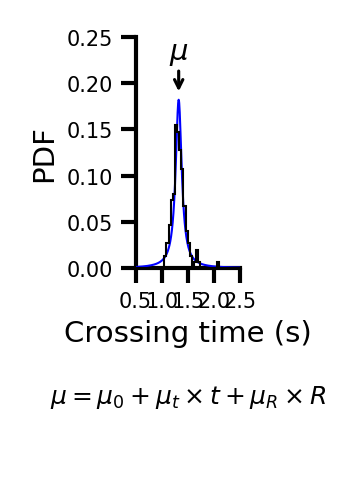

In [415]:
# crssing time first 10 min, all reward history pooled

def plot_mu(ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    animal = 'RatF02'
    session = 'RatF02_2021_07_22_18_14_16' 

    crossingtimes = prepare_data_running_times(sequence, [animal], [session])
    # crossingtimes = crossingtimes[animal][0][0]
    crossingtimes = [item for sublist in prepare_data_running_times(sequence, [animal], [session])[animal][0] for item in sublist]

    bins=np.linspace(0, 5, 125)
    ydata, xdata, _ = ax.hist(crossingtimes, bins=bins,
                    color='k', zorder=10, lw=.5,
                    #density=True,
                    weights=np.ones_like(crossingtimes) / len(crossingtimes),
                    histtype="step")
    
    x = np.linspace(0.0, 5, 1000)
    p = stats.cauchy.fit(crossingtimes)
    y = stats.cauchy.pdf(x, *p) /25
    ax.plot(x, y, color=plt.get_cmap('winter')(0), zorder=4, lw=0.5)

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([0.5, 1, 1.5, 2, 2.5])
    ax.set_ylim(0, .25)
    ax.set_xlabel('Crossing time (s)')
    ax.set_ylabel('PDF')


    x_peak = x[np.argmax(y)]
    y_peak = y[np.argmax(y)]

    # idle time arrow
    ax.annotate(text='', xy=(x_peak, y_peak), xytext=(x_peak, y_peak+.04), arrowprops=dict(arrowstyle='->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text=r'$\mu$', xy=(x_peak, y_peak), xytext=(x_peak, y_peak+.05), ha='center', va='center',
                xycoords='data', fontsize=7, zorder=5)

def equ_mu(ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    ax.axis("off")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.text(s=r'$\mu = \mu_0 + \mu_t \times t + \mu_R \times R$', x=0, y=.5, ha="center", va="center", fontsize=6)
    


fig, axs = plt.subplots(2, 1, figsize=(1, 1.5), gridspec_kw={'height_ratios': [3, 1]})
plot_mu(axs[0])
equ_mu(axs[1])

# 2A $\mu_0$

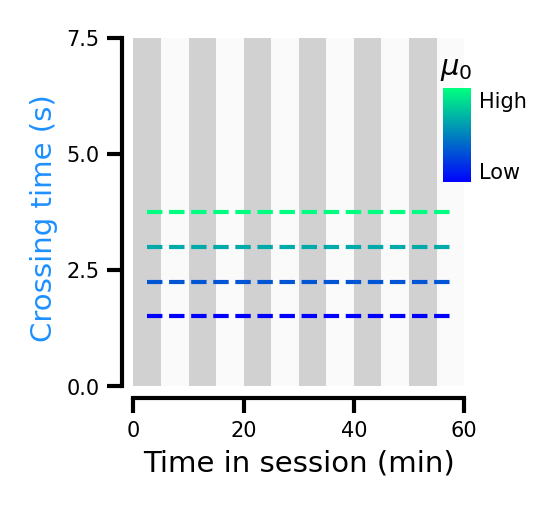

In [416]:
# plot variable median/mean fir each block
def Figure2A(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25]
    modifs = [-0.75, 0, 0.75, 1.5]
    
    cmap = plt.get_cmap('winter', len(modifs))
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif for i in range(0, len(blocks))],
                color=cmap(idx), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Crossing time (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2A(ax=ax)


l, b, h, w = 0.9, .65, 0.2, 0.06
ax1 = fig.add_axes([l, b, w, h])

plot_colorbar(ax=ax1, fig=fig, label=r'$\mu_0$', cmap='winter')

# 2B $\mu_t$

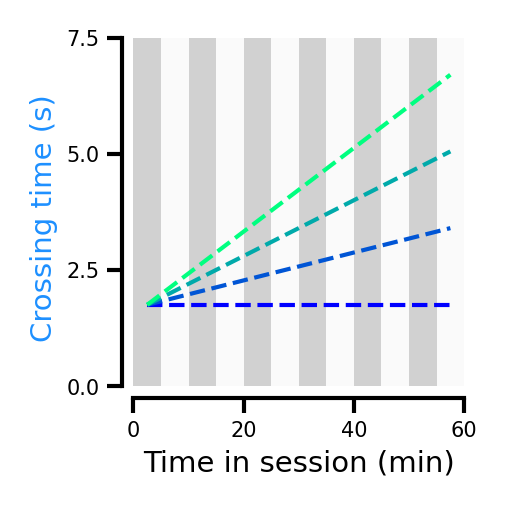

In [417]:
# plot variable median/mean fir each block
def Figure2B(ax=None):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [0, 0.15, .3, .45]
    cmap = plt.get_cmap('winter', len(modifs))
    
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + (i*modif) for i in range(0, len(blocks))],
                color=cmap(idx), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Crossing time (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2B(ax=ax)

# 2C $\mu_R$

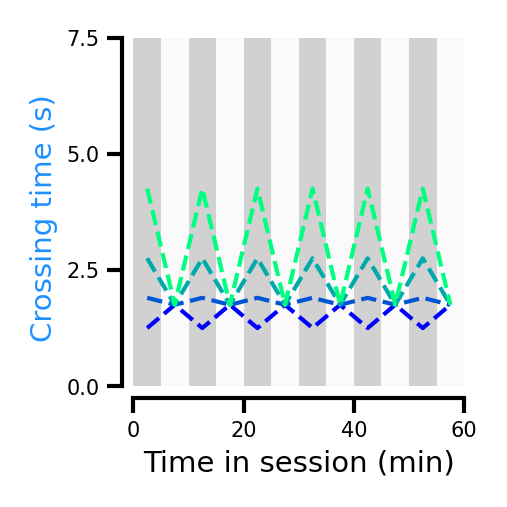

In [418]:
# plot variable median/mean fir each block
def Figure2C(ax=None):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    # dummy_data = [1.75, 2.7, 1.75, 2.75, 1.75, 2.75, 1.75, 2.7, 1.75, 2.75, 1.75, 2.80]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [-.5, .15, 1, 2.5]
    cmap = plt.get_cmap('winter', len(modifs))

    for idx, modif in enumerate(modifs):
        
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif if i % 2 == 0 else dummy_data[i] for i in range(0, len(blocks)) ],
                color=cmap(idx), ls='--')

    
    dummy_data = [1.25, 1.7, 1.2, 1.75, 1.2, 1.75, 1.25, 1.7, 1.30, 1.75, 1.25, 1.80]
 
    
    dummy_data = [1.25, 4.2, 1.2, 4.25, 1.2, 4.25, 1.25, 4.2, 1.30, 4.25, 1.25, 4.30] 


    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Crossing time (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2C(ax=ax)

# 2D model + data

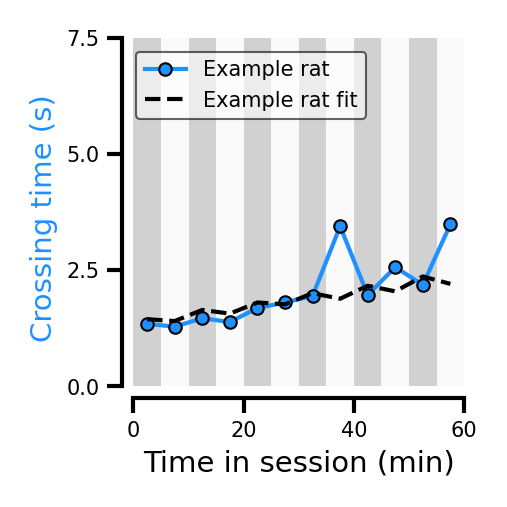

In [419]:
# plot variable median/mean fir each block
def Figure2D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
    # ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
    #         [dummy_data[i] for i in range(0, len(blocks))],  # or use median
    #         # marker='o', ms=3, 
    #         color='dodgerblue', 
    #         zorder=4, markeredgecolor='k', markeredgewidth=0.5,
    #         ls='--', label='Synthetic data')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Crossing time (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal = 'RatF02'
    session = 'RatF02_2021_07_22_18_14_16' 

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')


    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = ex_mu + bin*ex_mu_t + avg*ex_mu_R
            SIGMA[bin, avg] = ex_sigma + bin*ex_sigma_t + avg*ex_sigma_R

    m = []
    s = []
    for i in range(6):
        m.append(MU[i][0]+0.1*MU[i][1])
        m.append(MU[i][-1]+0.1*MU[i][-2])
        s.append(SIGMA[i][0]+0.1*SIGMA[i][1])
        s.append(SIGMA[i][-1]+0.1*SIGMA[i][-2])

    res = [np.median(generate_running_time(m[i], s[i], 1000)) for i in range(12)]
    
    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [res[i] for i in range(0, len(blocks))],
            color='k', ls='--', label='Example rat fit', zorder=5)


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2D(ax=ax)

# 2E schematic distance

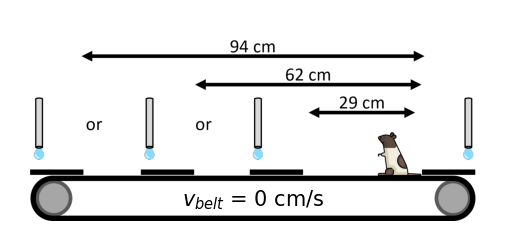

In [420]:
def Figure2E(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/Fig2E.png"

    img = plt.imread(path)
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{belt}$ = 0 cm/s', x=1745/2, y=666, ha="center", va="center", fontsize=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2E(ax=ax)

# 2FGH fit result dist

In [421]:
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]
for var, name in zip([mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R], ylabelsRUN):
    temp60 = [var[animal]['60'] for animal in animalList]
    temp90 = [var[animal]['90'] for animal in animalList]
    temp120= [var[animal]['120'] for animal in animalList]

    temp20 = [var[animal]['20'] for animal in animalList]
    temp10 = [var[animal]['10'] for animal in animalList]
    temp2 = [var[animal]['2'] for animal in animalList]
    temprev10= [var[animal]['rev10'] for animal in animalList]
    temprev20= [var[animal]['rev20'] for animal in animalList]

    F, p_dist = stats.friedmanchisquare(temp60, temp90, temp120)
    F, p_TM = stats.friedmanchisquare(temp20, temp10, temp2, temprev10, temprev20)

    # bonferroni correction, 6 tests
    alpha_dist = .05/6
    alpha_TM = .05/6
    # alpha_dist = .05/3
    # alpha_TM = .05/3
    print(f'{name} p_dist:{p_dist:.3f}{"*" if p_dist < alpha_dist else " "}  p_TM:{p_TM:.3f}{"*" if p_TM < alpha_TM else " "}')

    # post-hoc tests
    if p_dist < alpha_dist:
        sig = 0.05
        # wilcoxon signed rank test
        s, p = stats.wilcoxon(temp60, temp90)
        print(f'        60 vs 90: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp60, temp120)
        print(f'        60 vs 120: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp90, temp120)
        print(f'        90 vs 120: p={p:.4f}{"*" if p < sig else " "}')


    if p_TM < alpha_TM:
        sig = 0.05
        s, p = stats.wilcoxon(temp20, temp10)
        print(f'        20 vs 10: p={p:.4f}{"*" if p < sig else " "}')
        
        s, p = stats.wilcoxon(temp20, temp2)
        print(f'        20 vs 2: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp20, temprev10)
        print(f'        20 vs rev10: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp20, temprev20)
        print(f'        20 vs rev20: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp10, temp2)
        print(f'        10 vs 2: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp10, temprev10)
        print(f'        10 vs rev10: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp10, temprev20)
        print(f'        10 vs rev20: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp2, temprev10)
        print(f'        2 vs rev10: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temp2, temprev20)
        print(f'        2 vs rev20: p={p:.4f}{"*" if p < sig else " "}')

        s, p = stats.wilcoxon(temprev10, temprev20)
        print(f'        rev10 vs rev20: p={p:.4f}{"*" if p < sig else " "}')

        


$\mu_0$ p_dist:0.000*  p_TM:0.000*
        60 vs 90: p=0.0001*
        60 vs 120: p=0.0001*
        90 vs 120: p=0.0001*
        20 vs 10: p=0.0946 
        20 vs 2: p=0.0004*
        20 vs rev10: p=0.0003*
        20 vs rev20: p=0.0001*
        10 vs 2: p=0.0084*
        10 vs rev10: p=0.0006*
        10 vs rev20: p=0.0001*
        2 vs rev10: p=0.0026*
        2 vs rev20: p=0.0001*
        rev10 vs rev20: p=0.0015*
$\mu_t$ p_dist:0.005*  p_TM:0.006*
        60 vs 90: p=0.0084*
        60 vs 120: p=0.0181*
        90 vs 120: p=0.6788 
        20 vs 10: p=0.0151*
        20 vs 2: p=0.0001*
        20 vs rev10: p=0.0043*
        20 vs rev20: p=0.0084*
        10 vs 2: p=0.2078 
        10 vs rev10: p=0.0637 
        10 vs rev20: p=0.5245 
        2 vs rev10: p=0.7197 
        2 vs rev20: p=0.8469 
        rev10 vs rev20: p=0.7197 
$\mu_R$ p_dist:0.627   p_TM:0.161 
$\sigma_0$ p_dist:0.057   p_TM:0.001*
        20 vs 10: p=0.0353*
        20 vs 2: p=0.0637 
        20 vs rev10: p=0.0034*

In [422]:
for var, name in zip([mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R], ylabelsRUN):
    temp60 = [var[animal]['60'] for animal in animalList]
    temp90 = [var[animal]['90'] for animal in animalList]
    temp120= [var[animal]['120'] for animal in animalList]

    temp20 = [var[animal]['20'] for animal in animalList]
    temp10 = [var[animal]['10'] for animal in animalList]
    temp2 = [var[animal]['2'] for animal in animalList]
    temprev10= [var[animal]['rev10'] for animal in animalList]
    temprev20= [var[animal]['rev20'] for animal in animalList]

    F, p_dist = stats.friedmanchisquare(temp60, temp90, temp120)
    F, p_TM = stats.friedmanchisquare(temp20, temp10, temp2, temprev10, temprev20)


    print(stats.normaltest(temp60))
    print(stats.normaltest(temp90))
    print(stats.normaltest(temp120))

    print(stats.normaltest(temp20))
    print(stats.normaltest(temp10))
    print(stats.normaltest(temp2))
    print(stats.normaltest(temprev10))
    print(stats.normaltest(temprev20))
    print()




NormaltestResult(statistic=6.091231116960907, pvalue=0.047567022689610765)
NormaltestResult(statistic=0.18664812716178966, pvalue=0.9108982635078756)
NormaltestResult(statistic=0.07146412157636163, pvalue=0.9648987930725895)
NormaltestResult(statistic=1.2138384221680336, pvalue=0.545027399601735)
NormaltestResult(statistic=0.15633773742123902, pvalue=0.9248082421811571)
NormaltestResult(statistic=13.920413973535076, pvalue=0.0009489001444387442)
NormaltestResult(statistic=5.84315031933629, pvalue=0.05384880000443992)
NormaltestResult(statistic=14.014958648438391, pvalue=0.0009050871466864745)

NormaltestResult(statistic=2.201658448993794, pvalue=0.33259517325282845)
NormaltestResult(statistic=19.386217230047986, pvalue=6.170728177184538e-05)
NormaltestResult(statistic=12.41460967653243, pvalue=0.002014659988004426)
NormaltestResult(statistic=7.99817214600143, pvalue=0.01833238569713826)
NormaltestResult(statistic=3.0650497623369395, pvalue=0.21598963011690286)
NormaltestResult(statisti

/home/david/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [423]:
from statsmodels.stats.anova import AnovaRM
for var, name in zip([mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R], ylabelsRUN):
    temp60 = [var[animal]['60'] for animal in animalList]
    temp90 = [var[animal]['90'] for animal in animalList]
    temp120= [var[animal]['120'] for animal in animalList]

    data = pd.DataFrame({'rat': animalList*3,
                            'condition': ['60']*len(animalList) + ['90']*len(animalList) + ['120']*len(animalList),
                            'fit_param': temp60 + temp90 + temp120})
    # Checking normality
    _, p_normality = stats.normaltest(data['fit_param'])
    print(f'p-value for normality: {p_normality}')

    if p_normality > 0.05:
        print('Data is normally distributed')

        anova = AnovaRM(data=data, depvar='fit_param', subject='rat', within=['condition'])
        fit = anova.fit()
        print(fit.summary())

    else:
        print('Data is not normally distributed')
        print(stats.friedmanchisquare(temp60, temp90, temp120))
    
    print()

p-value for normality: 0.40170435361958773
Data is normally distributed
                 Anova
          F Value  Num DF  Den DF Pr > F
----------------------------------------
condition 223.6803 2.0000 28.0000 0.0000


p-value for normality: 4.489006055087688e-06
Data is not normally distributed
FriedmanchisquareResult(statistic=10.533333333333331, pvalue=0.005160784548998607)

p-value for normality: 3.0363831887685955e-05
Data is not normally distributed
FriedmanchisquareResult(statistic=0.9333333333333371, pvalue=0.6270890852730551)

p-value for normality: 1.463423082099942e-06
Data is not normally distributed
FriedmanchisquareResult(statistic=5.73333333333332, pvalue=0.05688823834610191)

p-value for normality: 0.0005648231825719966
Data is not normally distributed
FriedmanchisquareResult(statistic=0.4000000000000057, pvalue=0.8187307530779795)

p-value for normality: 6.324553694892646e-09
Data is not normally distributed
FriedmanchisquareResult(statistic=11.199999999999989, pvalue

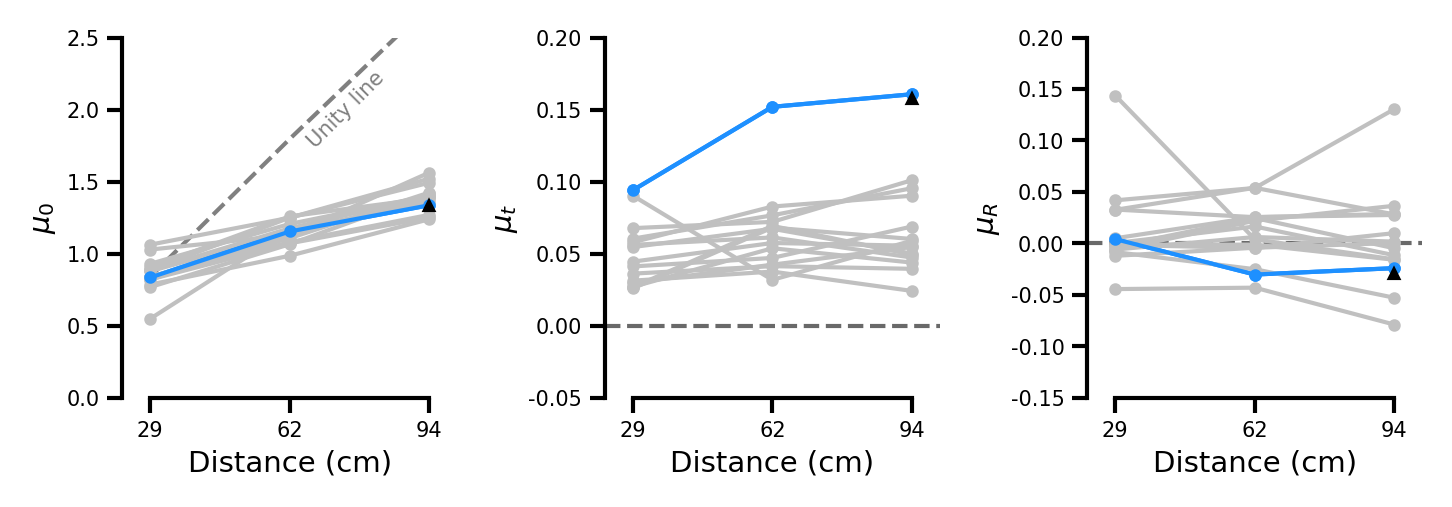

In [424]:
def Figure2F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_0[animal]["60"], mu_0[animal]["90"], mu_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2], [mu_0[animal]["60"], mu_0[animal]["90"], mu_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5)

    
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 2.5)
    ax.set_ylabel(r'$\mu_0$')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

    avg60 = np.median([mu_0[animal]["60"] for animal in animalList])
    ax.plot([0, 1, 2], [avg60, (62/29)*avg60, (94/29)*avg60], color='gray', linestyle='--', linewidth=1, alpha=1, zorder=0,)
    ax.text(s='Unity line', x=1.1, y=2, ha="left", va="center", fontsize=5, color='gray', rotation=45)


def Figure2G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, mu_t, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_t[animal]["60"], mu_t[animal]["90"], mu_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatF02':
            ax.plot([0, 1, 2], [mu_t[animal]["60"], mu_t[animal]["90"], mu_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    

    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.05, .2)
    ax.set_ylabel(r'$\mu_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)


def Figure2H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, mu_R, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_R[animal]["60"], mu_R[animal]["90"], mu_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2], [mu_R[animal]["60"], mu_R[animal]["90"], mu_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu_R, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.15, .2)
    ax.set_ylabel(r'$\mu_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
Figure2F(axs[0])
Figure2G(axs[1])
Figure2H(axs[2])

# 2I mean run speed Distance

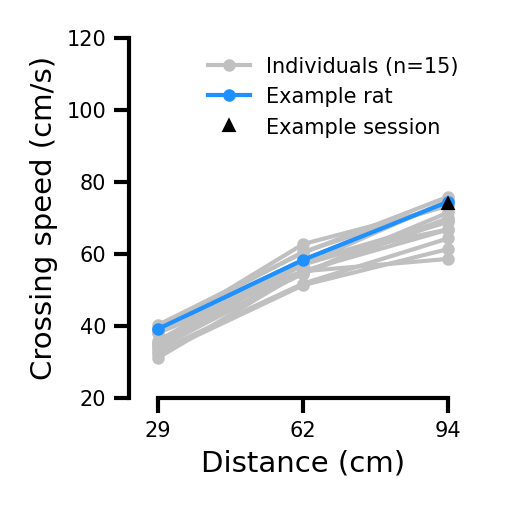

In [425]:
def Figure2I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["60", "90", "120"]
    run_speeds = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) <= 1:
                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2, label=f'Individuals (n={len(animalList)})')

        if animal == "RatF02":
            pickle.dump([np.median(run_speeds[cond][animal]) for cond in conds], open("picklejar/example_rat_run_speeds_dist.p", "wb"))
            ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10, label='Example rat')

    animal='RatF02'
    session='RatF02_2021_07_22_18_14_16'
    example_session_run_speeds = []
    params = get_from_pickle(root, animal, session, name="params.p")
    for elem in sequence[animal, session]:
        if get_block(sequence[animal, session][elem][0]) <= 1:
            if sequence[animal, session][elem][1] == 'run':
                tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                example_session_run_speeds.append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    ax.plot(2, np.median(example_session_run_speeds), color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")


    ax.set_ylim(20, 120)
    ax.set_yticks([20, 40, 60, 80, 100, 120])
    ax.set_ylabel("Crossing speed (cm/s)")


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]

    ax.legend(*zip(*unique), loc='best',# bbox_to_anchor=(0.01, 0.99), 
                                frameon=False, fontsize=5, markerscale=1, 
                                edgecolor='k', facecolor='w', 
                                # title='Legend for all figures:     ', title_fontsize=5
                                ).get_frame().set_linewidth(.5)
    


    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2I(ax=ax)

# 2J schematic vbelt

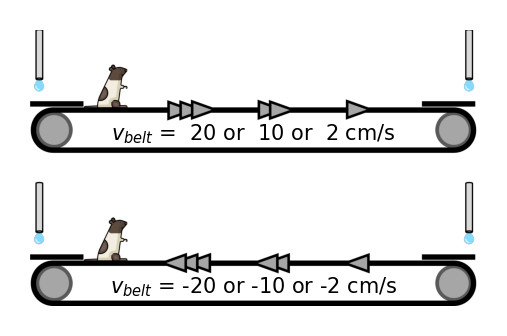

In [426]:
def Figure2J(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/Fig2J.png"

    img = plt.imread(path)
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{belt}$ =  20 or  10 or  2 cm/s', x=1745/2, y=405, ha="center", va="center", fontsize=5)
    ax.text(s=r'$v_{belt}$ = -20 or -10 or -2 cm/s', x=1745/2, y=1005, ha="center", va="center", fontsize=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2J(ax=ax)

# 2KLM fit results vbelt

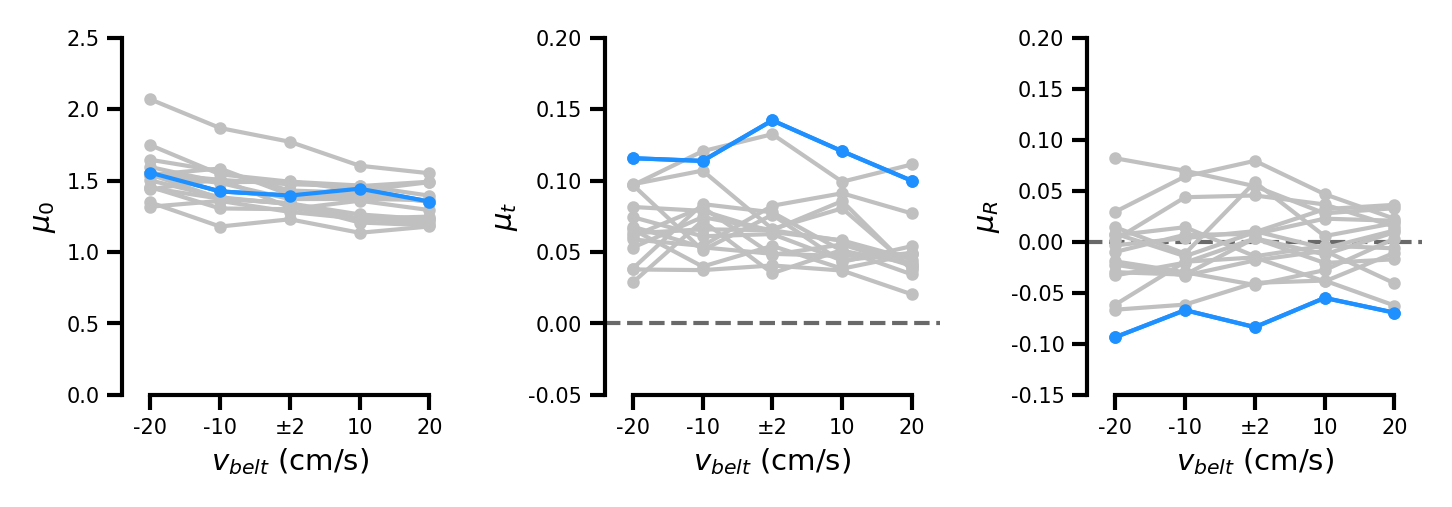

In [427]:
def Figure2K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["rev20"], mu_0[animal]["rev10"], mu_0[animal]["2"], mu_0[animal]["10"], mu_0[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
    
        if animal == "RatF02":
            ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["rev20"], mu_0[animal]["rev10"], mu_0[animal]["2"], mu_0[animal]["10"], mu_0[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 2.5)
    ax.set_ylabel(r'$\mu_0$')
    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)


def Figure2L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, mu_t, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_t[animal]["rev20"], mu_t[animal]["rev10"], mu_t[animal]["2"], mu_t[animal]["10"], mu_t[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatF02":
            ax.plot([0, 1, 2, 3, 4], [mu_t[animal]["rev20"], mu_t[animal]["rev10"], mu_t[animal]["2"], mu_t[animal]["10"], mu_t[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-.05, .2)
    ax.set_ylabel(r'$\mu_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)


def Figure2M(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, mu_R, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_R[animal]["rev20"], mu_R[animal]["rev10"], mu_R[animal]["2"], mu_R[animal]["10"], mu_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatF02":
            ax.plot([0, 1, 2, 3, 4], [mu_R[animal]["rev20"], mu_R[animal]["rev10"], mu_R[animal]["2"], mu_R[animal]["10"], mu_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-.15, .2)
    ax.set_ylabel(r'$\mu_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
Figure2K(axs[0])
Figure2L(axs[1])
Figure2M(axs[2])

# 2N mean run speed vbelt

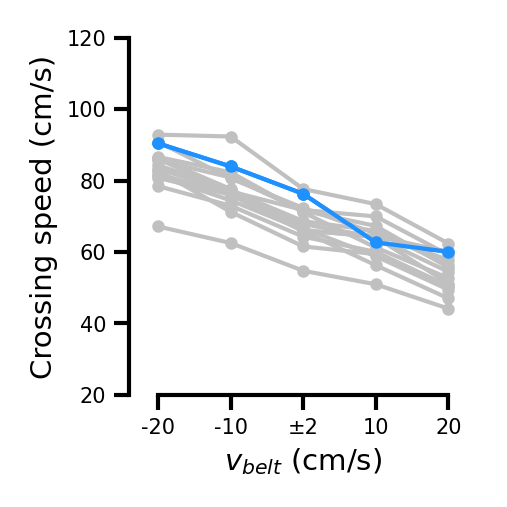

In [428]:
def Figure2N(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["TMrev20", "TMrev10", "TM2", "TM10", "TM20"]
    run_speeds = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [TMrev20, TMrev10, TM2, TM10, TM20]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) <= 1:
                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)
        if animal == 'RatF02':
            pickle.dump([np.median(run_speeds[cond][animal]) for cond in conds], open("picklejar/example_rat_run_speeds_tm.p", "wb"))
            ax.plot([0, 1, 2, 3, 4], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2, zorder=10)
                
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(20, 120)
    ax.set_yticks([20, 40, 60, 80, 100, 120])
    ax.set_ylabel("Crossing speed (cm/s)")
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2N(ax=ax)

# Figure 2

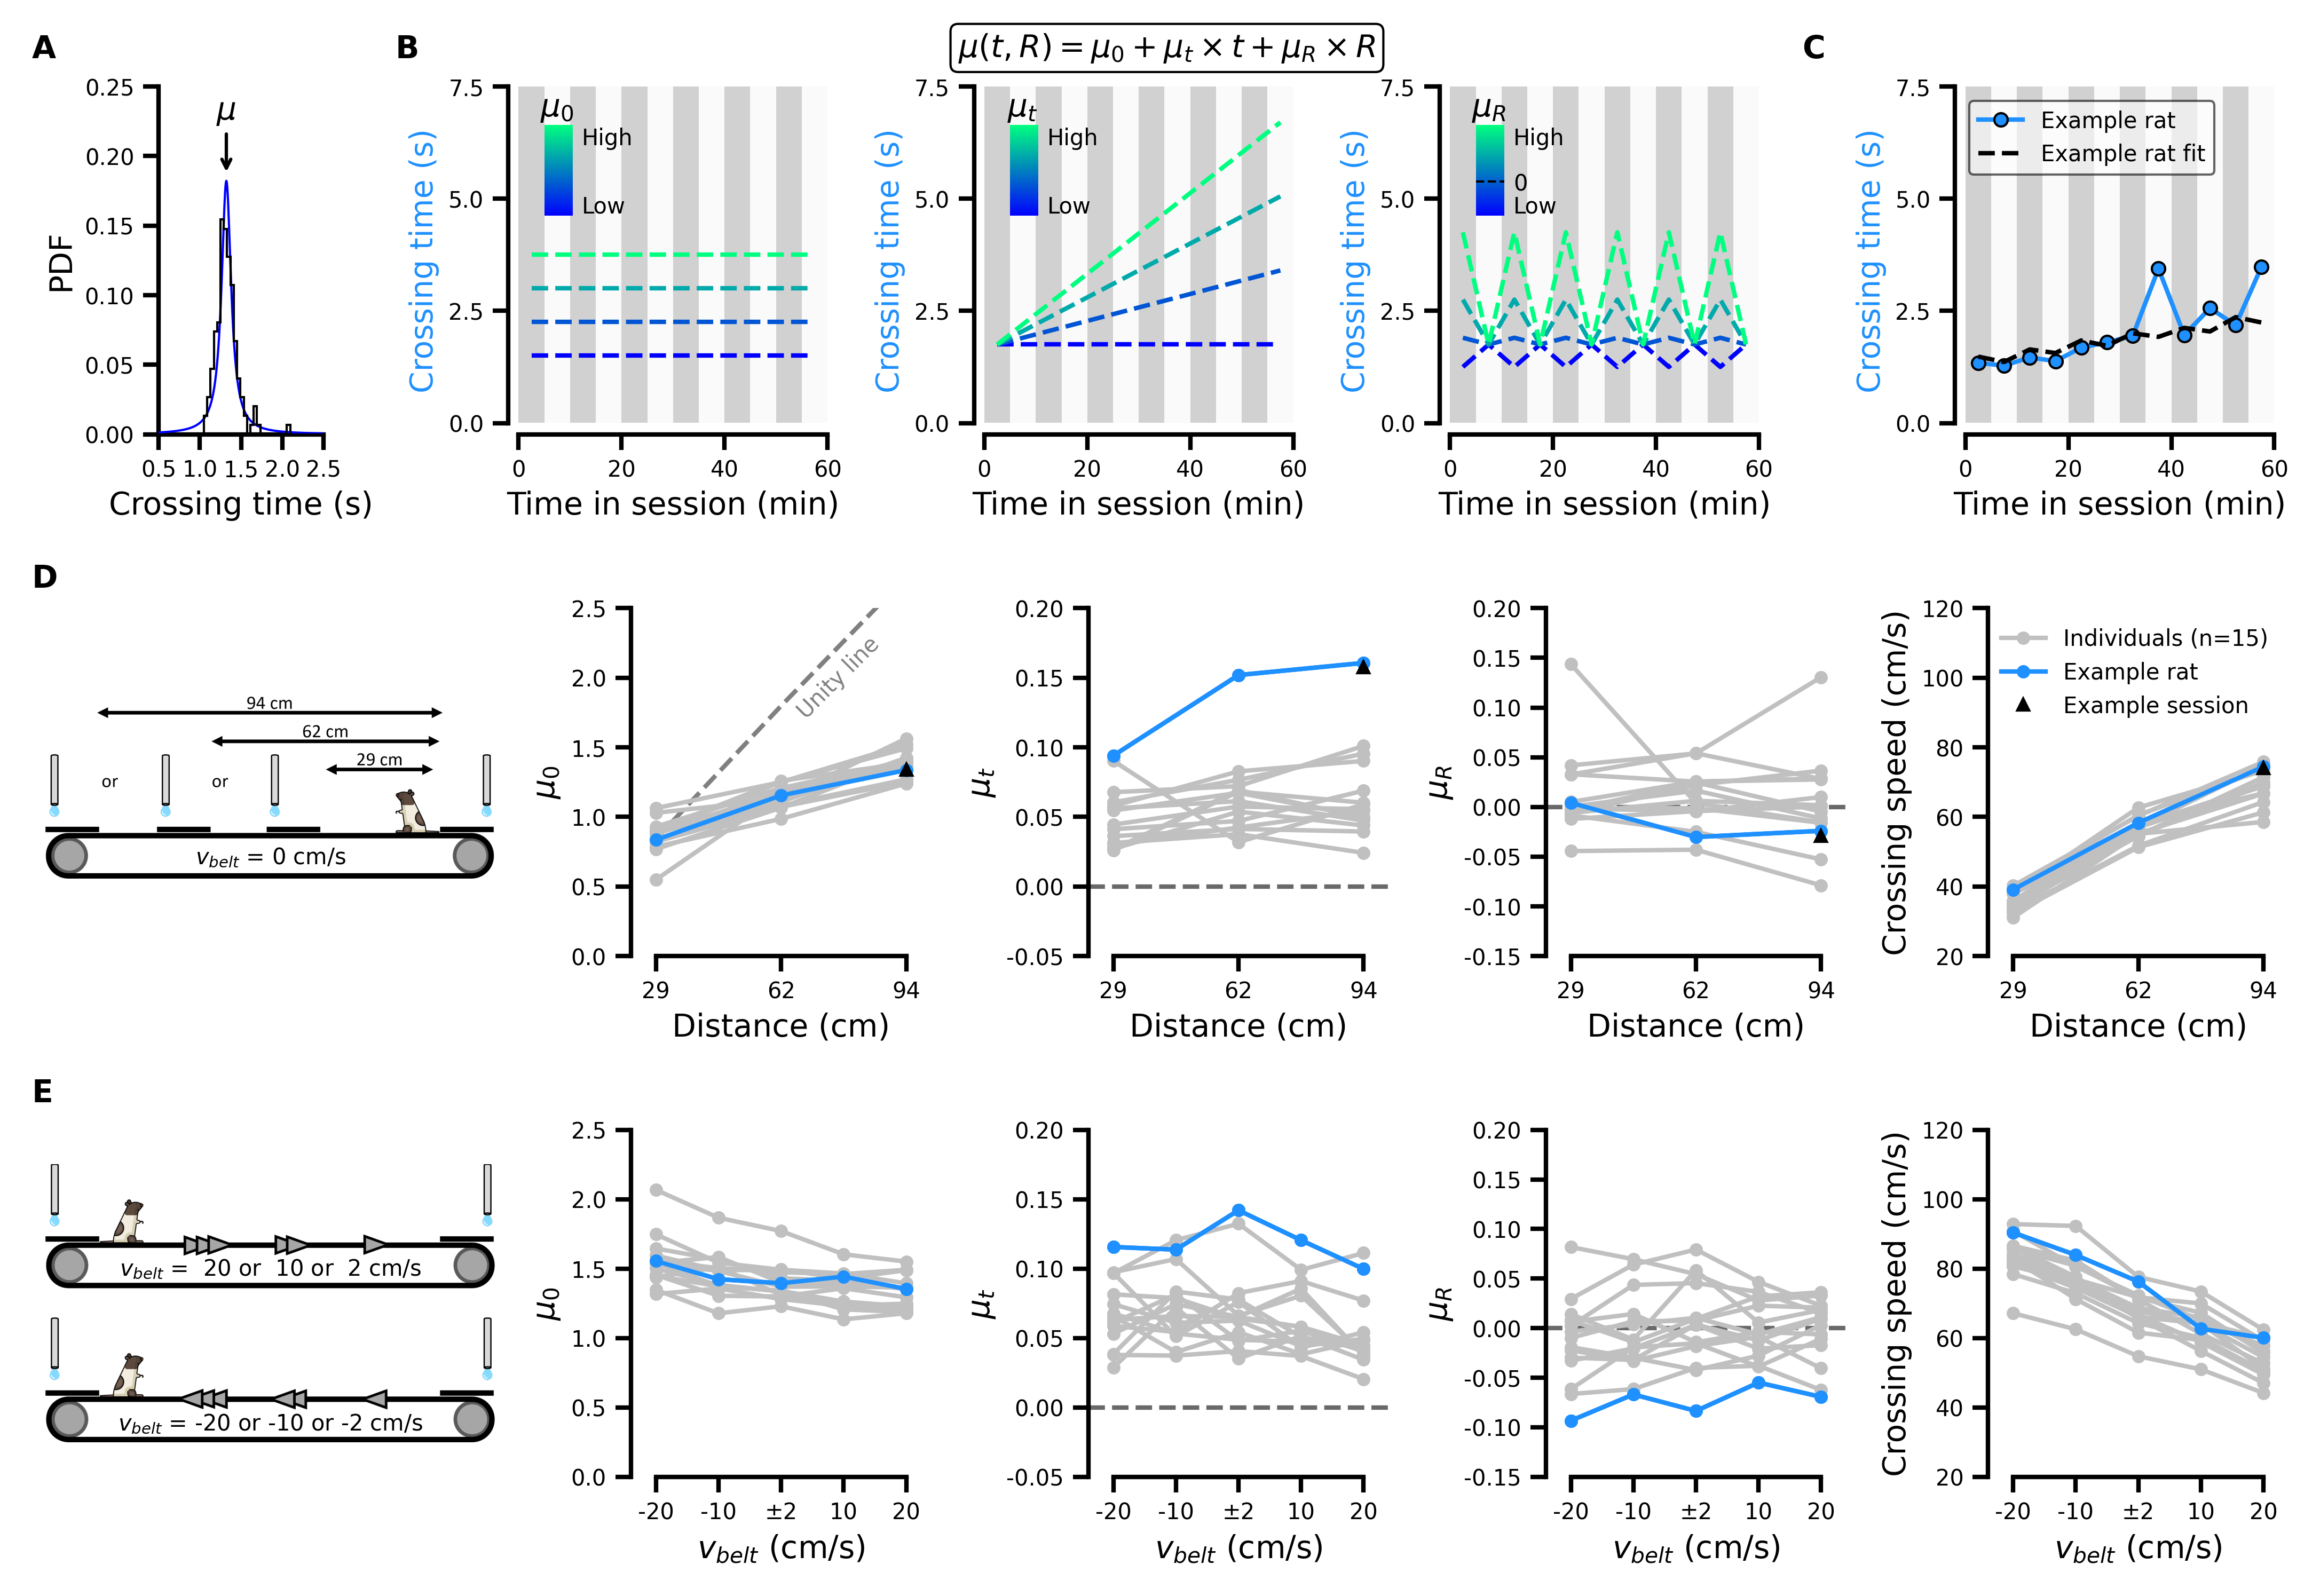

In [431]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(12)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 1, wspace=.5, hspace=.5, height_ratios=[9, 1, 9, 1, 9])

row1 = gs0[0].subgridspec(1, 7, width_ratios=[1, .01, 2, 2, 2, .1, 2])
explanation_mu = plt.subplot(row1[0, 0])
explanation_mu_0 = plt.subplot(row1[0, 2])
explanation_mu_t = plt.subplot(row1[0, 3])
explanation_mu_R = plt.subplot(row1[0, 4])
modeldata = plt.subplot(row1[0, 6])

row2 = gs0[2].subgridspec(1, 5, width_ratios=[3, 2, 2, 2, 2])
schematic_distances = plt.subplot(row2[0, 0])
fit_mu_0_distance = plt.subplot(row2[0, 1])
fit_mu_t_distance = plt.subplot(row2[0, 2])
fit_mu_R_distance = plt.subplot(row2[0, 3])
speed_distance = plt.subplot(row2[0, 4])

row3 = gs0[4].subgridspec(1, 5, width_ratios=[3, 2, 2, 2, 2])
schematic_vbelts = plt.subplot(row3[0, 0])
fit_mu_0_vbelt = plt.subplot(row3[0, 1])
fit_mu_t_vbelt = plt.subplot(row3[0, 2])
fit_mu_R_vbelt = plt.subplot(row3[0, 3])
speed_vbelt = plt.subplot(row3[0, 4])

figuresLabels={"A":[0.00, 1.00], "B":[0.16, 1.00], "C":[0.78, 1.00],
               "D":[0.00, 0.65], #"F":[0.22, 0.65], "G":[0.415, 0.65], "H":[0.61, 0.65], "I":[0.805, 0.65],
               "E":[0.00, 0.31], #"K":[0.22, 0.31], "L":[0.415, 0.31], "M":[0.61, 0.31], "N":[0.805, 0.31]
               }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

plot_mu(explanation_mu)
Figure2A(ax=explanation_mu_0)
Figure2B(ax=explanation_mu_t)
Figure2C(ax=explanation_mu_R)
Figure2D(ax=modeldata)

Figure2E(ax=schematic_distances)
Figure2F(ax=fit_mu_0_distance)
Figure2G(ax=fit_mu_t_distance)
Figure2H(ax=fit_mu_R_distance)
Figure2I(ax=speed_distance)

Figure2J(ax=schematic_vbelts)
Figure2K(ax=fit_mu_0_vbelt)
Figure2L(ax=fit_mu_t_vbelt)
Figure2M(ax=fit_mu_R_vbelt)
Figure2N(ax=speed_vbelt)



h, w = 0.06, 0.0125

cbarA = fig.add_axes([.2257, .9, w, h])
plot_colorbar(ax=cbarA, label=r'$\mu_0$', cmap='winter')

cbarB = fig.add_axes([.4308, .9, w, h])
plot_colorbar(ax=cbarB, label=r'$\mu_t$', cmap='winter')

cbarC = fig.add_axes([.6362, .9, w, h])
plot_colorbar(ax=cbarC, label=r'$\mu_R$', show_zero=150, cmap='winter')


plt.text(s=r'$\mu(t, R) = \mu_0 + \mu_t \times t + \mu_R \times R$', 
         x=0.5, y=1, ha="center", va="bottom", fontsize=7, 
         bbox=dict(facecolor='none', edgecolor='k', alpha=1, boxstyle='round, pad=.25', linewidth=.5), 
         transform=plt.gcf().transFigure)


plt.savefig("/home/david/Desktop/code/Figure_2.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

In [430]:
<

SyntaxError: invalid syntax (4056019114.py, line 1)

In [ ]:
# def effort_cost(T, D=1, alpha=1, vbelt=0):
#     return alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T)

def effort_cost(T, D=1, alpha=1, vbelt=0, power_effort=1):
    np.seterr(divide='ignore', invalid='ignore')
    vmax = (D - vbelt * T) / (T)
    return alpha * T * (vmax ** power_effort)

def time_cost(T, beta=1, power_time=1):
    return beta*T ** power_time


def plot_model(D=1, vbelt=0, alpha=1, beta=1, power_effort=2, power_time=3):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    T = np.linspace(0, 2, 100)
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort), label=r'$C_v$', color='r')
    ax.plot(T, time_cost(T, beta, power_time), label=r'$C_t$', color='g')
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time), label=r'$C_v + C_t$', color='k')
    # argmin of total cost
    ax.plot(T[np.nanargmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))], 
            np.nanmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time)),
            'o', color='k')#, label=r'$T^*$')

    ax.set_xlabel('Crossing time (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.legend()
    ax.set_ylim(-.5, 5)
    ax.set_xlim(-.25, 2.25)
    topt = T[np.nanargmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))]
    ax.set_xticks([0, topt, 1, 2])
    ax.set_xticklabels([0, r'$T_{opt}$', 1, 2])

    ax.spines['left'].set_bounds(0, 5)
    ax.spines['bottom'].set_bounds(0, 2)


interactive_plot = interactive(plot_model, D=(0, 2, .1), vbelt=(-.2, .2, 0.01), 
alpha=(0, 50.0, 0.5), beta=(0, 5, 0.5), 
power_effort=(0, 5, 0.1), power_time=(0, 5, 0.1))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='D', max=2.0), FloatSlider(value=0.0, description='vb…

# suppl

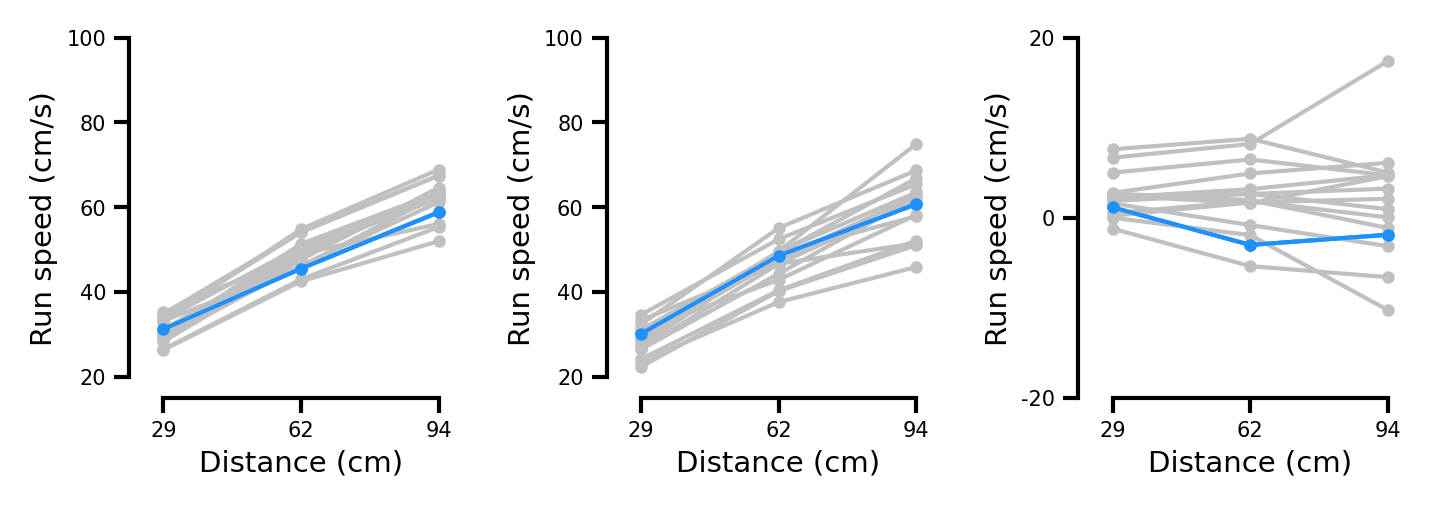

In [ ]:
def FigureS2I(axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    conds = ["60", "90", "120"]
    run_speeds90 = {k: {a: [] for a in animalList} for k in conds}
    run_speeds10 = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if sequence[animal, session][elem][1] == 'run':
                        tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                        if get_block(sequence[animal, session][elem][0]) %2 == 0:
                            run_speeds90[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)
                        else:
                            run_speeds10[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        axs[0].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)
        axs[1].plot([0, 1, 2], [np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        axs[2].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) - np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        if animal == "RatF02":
            axs[0].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)
            axs[1].plot([0, 1, 2], [np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)
            
            axs[2].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) - np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)



    # animal='RatF02'
    # session='RatF02_2021_07_22_18_14_16'
    # example_session_run_speeds = []
    # params = get_from_pickle(root, animal, session, name="params.p")
    # for elem in sequence[animal, session]:
    #     if sequence[animal, session][elem][1] == 'run':
    #         tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
    #         example_session_run_speeds.append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    # ax.plot(2, np.median(example_session_run_speeds), color='black', marker='^', zorder=10, markersize=2, linewidth=0)

    for ax in axs:
        ax.set_xlim(-0.25, 2.25)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["29", "62", "94"])
        ax.set_xlabel("Distance (cm)")


        ax.set_ylim(15, 100)
        ax.set_yticks([20, 40, 60, 80, 100])
        ax.set_ylabel("Run speed (cm/s)")


        ax.spines['left'].set_bounds(20, 100)
        ax.spines['bottom'].set_bounds(0, 2)

    axs[2].set_ylim(-20, 20)
    axs[2].spines['left'].set_bounds(-20, 20)
    axs[2].set_yticks([-20, 00, 20])

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
FigureS2I(axs=axs)

[39.58839798912963, 56.94630658669116, 74.03565885278887]


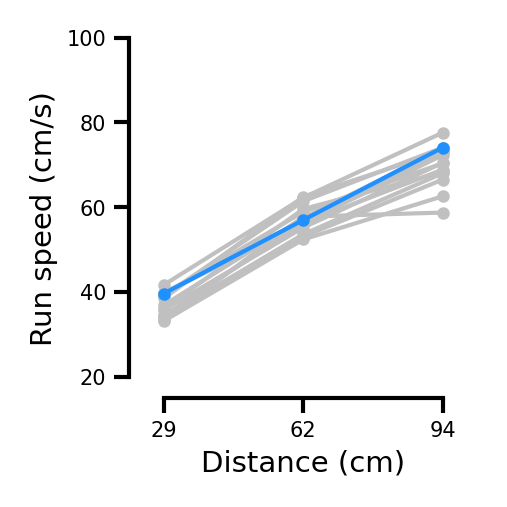

In [ ]:
def Figure2I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["60", "90", "120"]
    run_speeds = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) == 0:

                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        if animal == "RatF02":
            print([np.median(run_speeds[cond][animal]) for cond in conds])
            ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)


    ax.set_xlim(-0.25, 2.25)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")


    ax.set_ylim(15, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_ylabel("Run speed (cm/s)")


    ax.spines['left'].set_bounds(20, 100)
    ax.spines['bottom'].set_bounds(0, 2)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2I(ax=ax)